<a href="https://colab.research.google.com/github/italati/AI-Deep-Learning-Lab-2023/blob/it-nb-01/sessions/ct-body-part%20/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Automatic Labeling of Body CT Images

### In this session, we will explore how we can utilize a pre-trained machine learning algorithm to predict the chest, abdomen, or pelvis slices in a body CT.

*The pre-trained algorithm utilized in this notebook was developed by Ian Pan, MD. ai, and modified by Anouk Stein, MD.ai and Ross Filice MD, MedStar Georgetown University Hospital. The training code can be found [here](https://github.com/RSNA/AI-Deep-Learning-Lab-2023/blob/main/sessions/ct-body-part/train.ipynb).*



Learning Objectives:

> 1.   Evaluate an artificial intelligence model designed to determine body part in CT after development.
> 2.   Learn how to interpret raw outputs from this model.
> 3.   Build graphs and visualizations to help understand performance.




## Acquire Image Data and Pre-trained Model

We will clone the bodypart repository from github which includes the data we will use for this tutorial.

In [ ]:
!git clone https://github.com/rwfilice/bodypart.git

Cloning into 'bodypart'...
remote: Enumerating objects: 4624, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 4624 (delta 10), reused 41 (delta 7), pack-reused 4580
Receiving objects: 100% (4624/4624), 1.35 GiB | 18.21 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (4604/4604), done.


## Install Packages

Google Colab comes preloaded with several packages that we can use but does not include everything. Pydicom is a package that will allow us to read, modify, and write DICOM data easily in python. We will install it here.

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00


## Import Python packages


In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import pandas as pd
from keras import activations
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras import Model
import cv2
from pathlib import Path
import re
from scipy.ndimage.interpolation import zoom
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input
import seaborn as sns
import sys
sys.path.insert(0,'/content/bodypart/')
from saliency import *

np.set_printoptions(suppress=True,threshold=3)

<ipython-input-3-85a01be79322>:14: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


## Load and Convert Images

Here we will create a list of the paths to our DICOM images which are stored in numpy arrays.

We will use the glob function in the glob module to create a list with the pathname of all our test images using a specific pattern.

In [ ]:
#Provide path to test images
testPath = Path('bodypart/testnpy')
testList = list(sorted(testPath.glob('**/*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))

In [ ]:
testList

[PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-1.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-2.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-3.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-4.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-5.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-6.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-7.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-8.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-9.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-10.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-11.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-12.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-13.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-14.npy'),
 

Now that we have a list of our test images, we need to define two functions. The first function will return the DICOM image array from the stored numpy file when provided with the path. The second function will convert our 16 bit DICOM image array into an 256 x 256 pixel 8 bit image array. We will use these functions to load and process our images before feeding them into our model.

In [ ]:
def get_dicom_and_uid(path_to_npy):
    '''
    Given a filepath, return the npy file and corresponding SOPInstanceUID.
    '''
    path_to_npy = str(path_to_npy)
    dicom_file = np.load(path_to_npy)
    uid = path_to_npy.split('/')[-1].replace('.npy', '')
    return dicom_file, uid

In [ ]:
def convert_dicom_to_8bit(npy_file, width, level, imsize=(256.,256.), clip=True):
    '''
    Given a DICOM file, window specifications, and image size,
    return the image as a Numpy array scaled to [0,255] of the specified size.
    '''
    array = npy_file.copy()
    #array = array + int(dicom_file.RescaleIntercept) #we did this on preprocess
    #array = array * int(dicom_file.RescaleSlope) #we did this on preprocess
    array = np.clip(array, level - width / 2, level + width / 2)
    # Rescale to [0, 255]
    array -= np.min(array)
    array /= np.max(array)
    array *= 255.
    array = array.astype('uint8')

    if clip:
    # Sometimes there is dead space around the images -- let's get rid of that
        nonzeros = np.nonzero(array)
        x1 = np.min(nonzeros[0]) ; x2 = np.max(nonzeros[0])
        y1 = np.min(nonzeros[1]) ; y2 = np.max(nonzeros[1])
        array = array[x1:x2,y1:y2]

    # Resize image if necessary
    resize_x = float(imsize[0]) / array.shape[0]
    resize_y = float(imsize[1]) / array.shape[1]
    if resize_x != 1. or resize_y != 1.:
        array = zoom(array, [resize_x, resize_y], order=1, prefilter=False)
    return np.expand_dims(array, axis=-1)

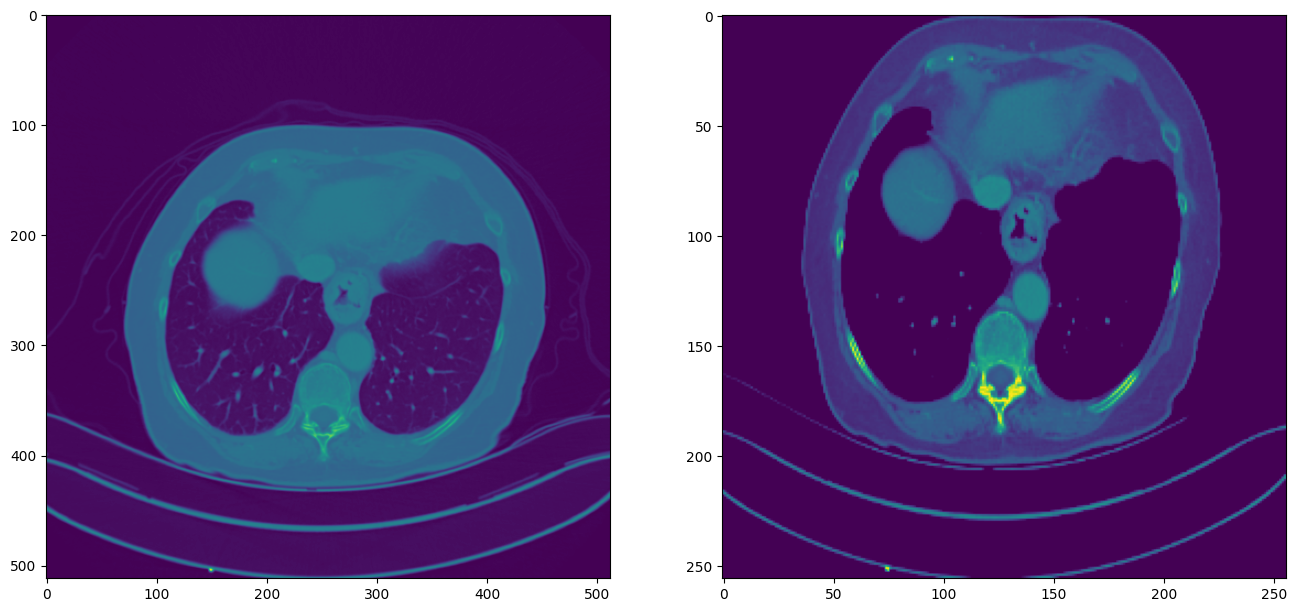

In [ ]:
dicom_file, uid = get_dicom_and_uid('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-74.npy')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(dicom_file)
plt.subplot(1,2,2)
plt.imshow(convert_dicom_to_8bit(dicom_file, 1000, 250).reshape((256,256)))

## Load our stored model and trained weights

In order to recreate our model to make inferences, we will load our stored model architecture and its pre-trained weights. The model is stored in JSON format and it's weights are stored in a H5 file.

In [ ]:
from keras.models import model_from_json
json_file = open('bodypart/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.load_weights('bodypart/tcga-mguh-multilabel.h5')  #federated

## Predict
Now we will define a function that will allow us to load and process our test images, and feed them into our algorithm for a prediction.

In [ ]:
#Inference
IMSIZE = 256
WINDOW_LEVEL, WINDOW_WIDTH = 50, 500
def predict(model, images, imsize):
    '''
    Small modifications to data generator to allow for prediction on test data.
    '''
    test_arrays = []

    test_probas = []
    test_uids   = []

    #iterate through the testPath list and predict on each slice
    for im in images:
        dicom_file, uid = get_dicom_and_uid(im)
        try:
            array = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL,
                                    imsize=(imsize,imsize))
        except:
            continue

        array = preprocess_input(array, mode='tf')
        test_arrays.append(array)

        test_probas.append(model.predict(np.expand_dims(array, axis=0)))
        test_uids.append(uid)
    return test_uids, test_arrays, test_probas


When we run the following cell, we use the function we defined above to predict and store our results in three separate lists.

The uids list contains the unique identifier for each DICOM slice, the X list contains a 3D array of the image pixel data for each slice, and the y_prob list contains a 1D array containing the prediction for each slice.

In [ ]:
uids, X, y_prob = predict(model, testList, IMSIZE)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


We will then store this information into a pandas dataframe, which is a tabular data structure.

In [ ]:
test_pred_df = pd.DataFrame({'uid': uids, 'X': X, 'y_prob': y_prob})

## Visualizing Our Results

Let's take a look at our pandas dataframe we created in the last cell.

In [ ]:
test_pred_df

,uid,X,y_prob
0,d2bb80e260ba5cd45aaaba9617f40f0d-1,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.9951314, 0.028154833, 5.2608455e-05]]"
1,d2bb80e260ba5cd45aaaba9617f40f0d-2,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.98862576, 0.018155046, 0.0015503502]]"
2,d2bb80e260ba5cd45aaaba9617f40f0d-3,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.974627, 0.02149323, 0.0022077668]]"
3,d2bb80e260ba5cd45aaaba9617f40f0d-4,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.97096586, 0.019585604, 0.0014411892]]"
4,d2bb80e260ba5cd45aaaba9617f40f0d-5,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.98722494, 0.0068291244, 0.0013882535]]"
...,...,...,...
211,d2bb80e260ba5cd45aaaba9617f40f0d-212,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.014090139, 0.0020031112, 0.98827434]]"
212,d2bb80e260ba5cd45aaaba9617f40f0d-213,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.009450647, 0.000626273, 0.9948342]]"
213,d2bb80e260ba5cd45aaaba9617f40f0d-214,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.0032771165, 0.00041209726, 0.99752456]]"
214,d2bb80e260ba5cd45aaaba9617f40f0d-215,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.0018993584, 0.00013068228, 0.99837625]]"


Now we will create three separate arrays from the "y_prob" column from the pandas dataframe. As seen above, the y_prob column contains an array for each image with three separate probabilities (one for each class: chest, abdomen, and pelvis). We will store each in a separate array called chest, abd, and pelv.

In [ ]:
test_pred_df.apply(lambda row: row['y_prob'], axis=1)

0        [[0.9951314, 0.028154833, 5.2608455e-05]]
1        [[0.98862576, 0.018155046, 0.0015503502]]
2           [[0.974627, 0.02149323, 0.0022077668]]
3        [[0.97096586, 0.019585604, 0.0014411892]]
4       [[0.98722494, 0.0068291244, 0.0013882535]]
                          ...                     
211      [[0.014090139, 0.0020031112, 0.98827434]]
212        [[0.009450647, 0.000626273, 0.9948342]]
213    [[0.0032771165, 0.00041209726, 0.99752456]]
214    [[0.0018993584, 0.00013068228, 0.99837625]]
215    [[0.0029322933, 0.00023197268, 0.99783915]]
Length: 216, dtype: object

In [ ]:
chest = np.stack(test_pred_df['y_prob'])[:,0][:,0]
abd = np.stack(test_pred_df['y_prob'])[:,0][:,1]
pelv = np.stack(test_pred_df['y_prob'])[:,0][:,2]

chest, abd, pelv

(array([0.9951314 , 0.98862576, 0.974627  , ..., 0.00327712, 0.00189936,
        0.00293229], dtype=float32),
 array([0.02815483, 0.01815505, 0.02149323, ..., 0.0004121 , 0.00013068,
        0.00023197], dtype=float32),
 array([0.00005261, 0.00155035, 0.00220777, ..., 0.99752456, 0.99837625,
        0.99783915], dtype=float32))

Now we can plot these probability arrays on a graph.

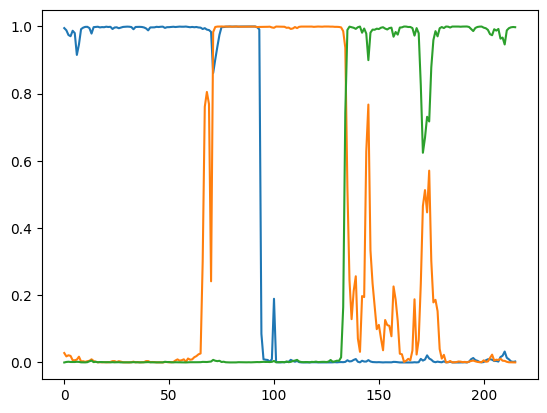

In [ ]:
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

Average over 5 slices to smooth out some of the spikes and see our 3 regions more clearly.



In [ ]:
numaveslices = 5
avepreds = []
allpreds = np.stack(test_pred_df['y_prob'])[:,0]
for idx,arr in enumerate(allpreds):
    low = int(max(0,idx-(numaveslices-1)/2))
    high = int(min(len(allpreds),idx+(numaveslices+1)/2))
    avepreds.append(np.mean(allpreds[low:high],axis=0))

chest = np.stack(avepreds)[:,0]
abd = np.stack(avepreds)[:,1]
pelv = np.stack(avepreds)[:,2]

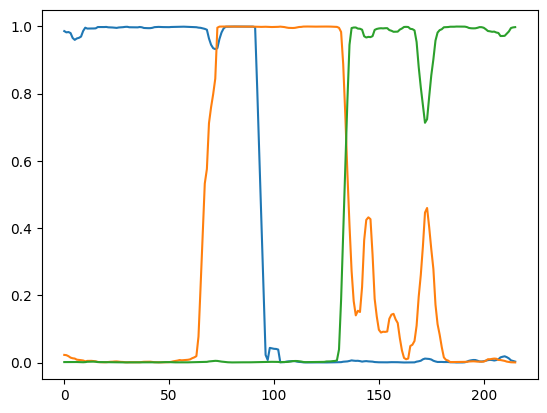

In [ ]:
#plot averaged over 5 slices
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

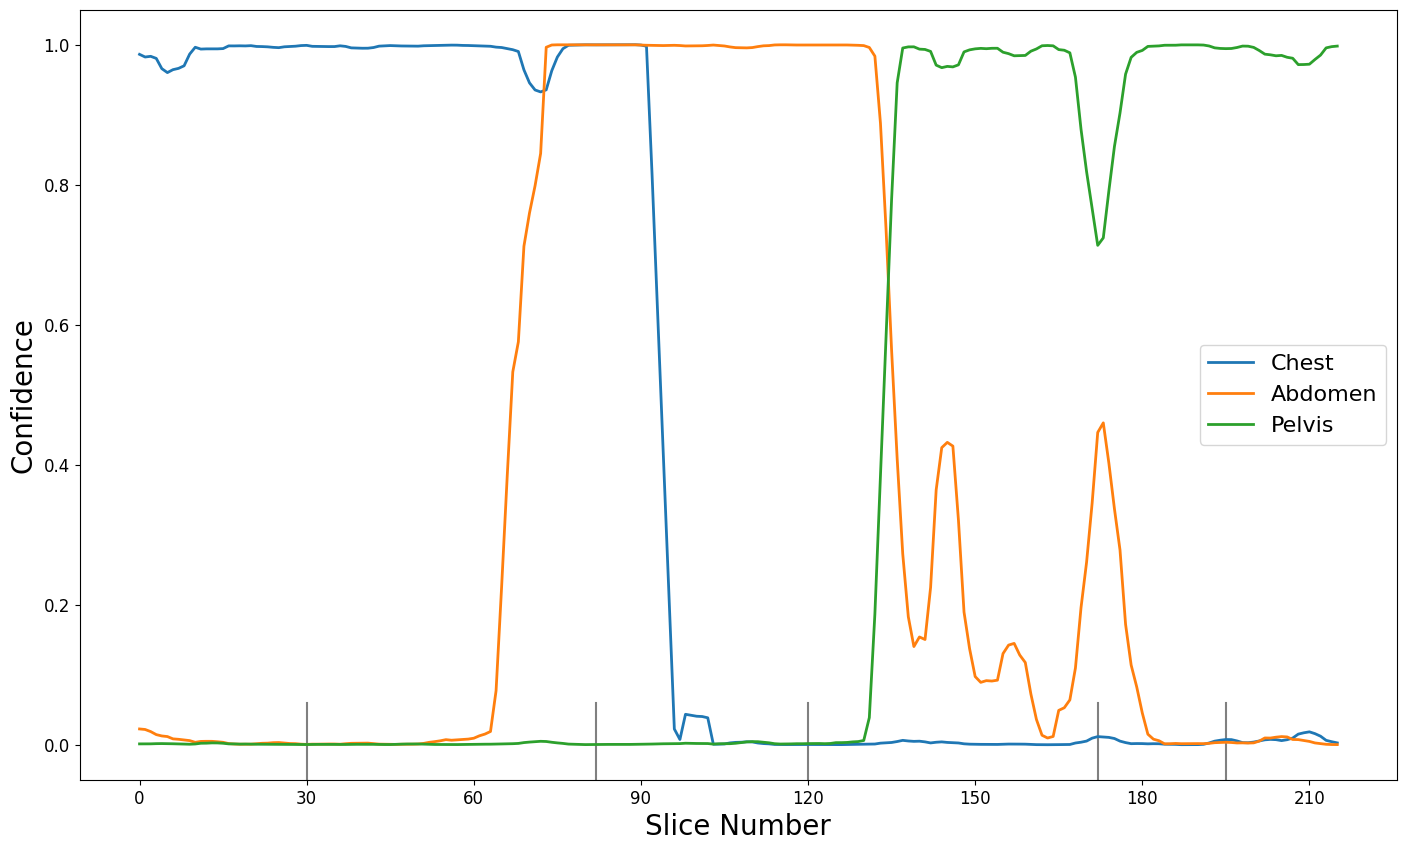

In [ ]:
#plot averaged over 5 slices, making it look fancy
fig, ax1 = plt.subplots(figsize=(17,10))
ax1.set_xlabel("Slice Number", fontsize=20)
ax1.set_ylabel("Confidence", fontsize=20)
plt.xticks([0,30,60,90,120,150,180,210],fontsize=12)
plt.yticks(fontsize=12)
ax1.axvline(30,color='gray',ymax=0.1)
ax1.axvline(82,color='gray',ymax=0.1)
ax1.axvline(120,color='gray',ymax=0.1)
ax1.axvline(172,color='gray',ymax=0.1)
ax1.axvline(195,color='gray',ymax=0.1)
plt.plot(chest,linewidth=2,label="Chest")
plt.plot(abd,linewidth=2,label="Abdomen")
plt.plot(pelv,linewidth=2,label="Pelvis")
plt.legend(fontsize=16)

Lets take a look at our images to see how our model is doing.

In [ ]:
def displayImages(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, clip=False)
        plt.subplot(1, numimgs, idx+1),
        plt.imshow(img[...,0],cmap='gray')
        plt.title(labels[idx])
        plt.axis('off')

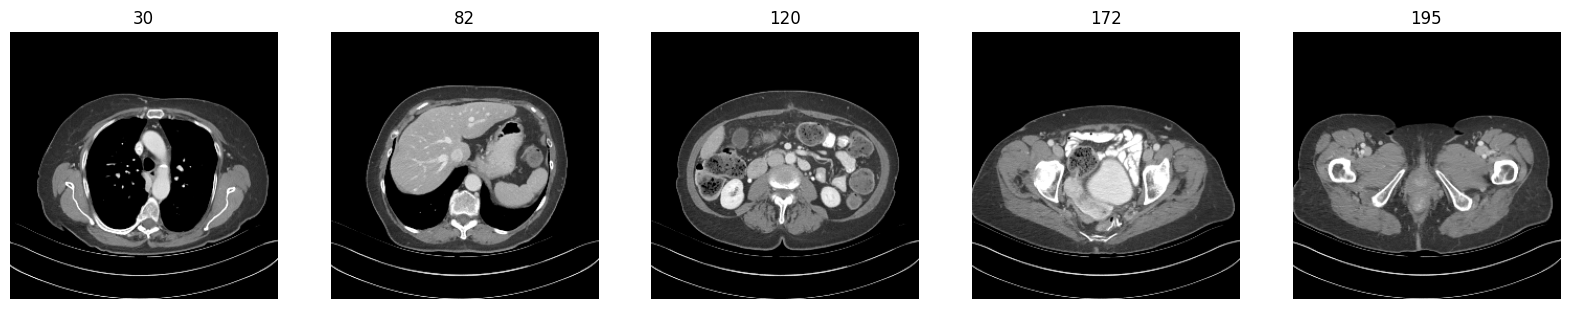

In [ ]:
displayImages([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

# Saliency Maps / Bounding Boxes

In this part of the tutorial, we will produce visual explanation heat maps that will help us understand how our algorithm makes decisions. This can help us visualize our model's mistakes and ultimately improve our model going forward.

We will use the keras-vis library, which is a package that is already preloaded in Google Colab. It is a toolkit for visualizing and debugging trained keras neural network models. The documentation can be found [here.](https://pypi.org/project/tf-keras-vis/)

At a high level, we will make use of gradients to determine pixel importance in the original image. There are many different algorithms that we may use to create saliency maps. For our example, we will use Grad-CAM, which is generally more applicable and requires less modifications to our network architecture.

Intuitively, grad-CAM works by numerically computing the gradient of the class output with respect to the input image. If certain pixels have a high gradient value, they have a strong contribution for prediction for that particular class. If they have a low gradient value, then they may not be as important for prediction.

Therefore, we can use these gradients to highlight input regions that cause the most change in the output. Intuitively this should highlight salient image regions that most contribute towards the output.

The following cell will provide us a summary of our model.

In [ ]:
model.summary()
print(len(model.layers))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         288       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
layer_idx = 156 #Index of last layer
penultimate_layer=151 #Index of last convolutional layer
#model.layers[-1].activation = activations.linear #Make the last layer linear (we don't need to, since the last layer is already linear in our case
model.save('bodypart/grad_cm_5.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_gradcam = load_model('bodypart/grad_cm_5.hdf5')

Here we are creating a python dictionary which allows us to define our labels according to their index (in our "y_prob" array that our model outputs). This will help us label our resulting image with the highest probability prediction.

In [ ]:
labels_dict1 = {'Chest':0,
               'Abdomen':1,
               'Pelvis':2}
#mapping of labels to index

labels_dict2 = {0:'Chest',
               1:'Abdomen',
               2:'Pelvis'}
#mapping of index to labels
N_CLASSES = len(labels_dict1)

Now we can define our function that will predict on an input image, produce a saliency map of the prediction, and then subsequently overlay the saliency map onto our image.

In [ ]:
def displayImages_saliency_maps(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL,
                            imsize=(IMSIZE,IMSIZE))

        array = preprocess_input(img, mode='tf')
        probs = model.predict(np.expand_dims(array, axis=0)) #Make prediction on the given input image
        index = np.argmax(probs) #Store the index of the class with the highest probability (0,1, or 2)
        final_pred = labels_dict2[np.argmax(probs)] #Find the label of the prediction
        saliency_map = visualize_cam(model_gradcam, layer_idx , filter_indices=index, seed_input=array,
                              penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None,grad_modifier=None) #Get the saliency maps of the prediction
        #normalize saliency map so it can be overlayed on image
        saliency_map = (saliency_map-saliency_map.min())/(saliency_map.max()-saliency_map.min())
        heatmap = np.uint8(cm.jet(saliency_map[...,0])[..., :3] * 255)
        original = np.uint8(cm.gray(img[...,0])[..., :3] * 255)

        #Overlay the saliency map on the input image
        overlaid_image = overlay(heatmap, original,0.2)

        plt.subplot(1, numimgs, idx+1)
        plt.imshow(overlaid_image)
        plt.title(f'{final_pred}:{probs[0][index]}')
        plt.axis('off')

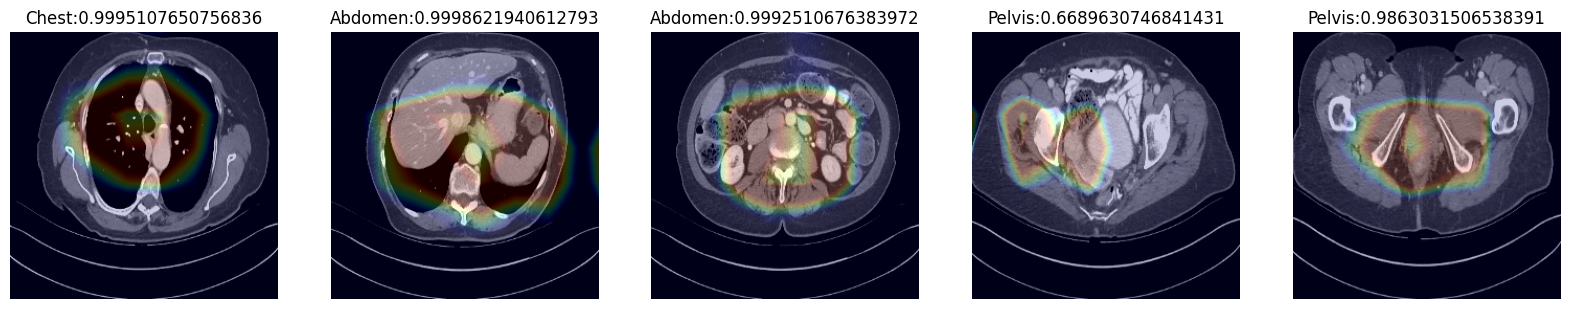

In [ ]:
displayImages_saliency_maps([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

Here we can utilize the saliency maps we produce to create bounding boxes around the region of interest with the highest prediction region.

We use the opencv python package which is an open source computer vision/machine learning library.

In [ ]:
def displayImages_with_bbox(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL,
                            imsize=(IMSIZE,IMSIZE))

        array = preprocess_input(img, mode='tf')
        probs = model.predict(np.expand_dims(array, axis=0)) #Make prediction on the given input image
        indice = np.argmax(probs)
        final_pred = labels_dict2[np.argmax(probs)] #Find the label of the prediction
        saliency_map = visualize_cam(model_gradcam, layer_idx , filter_indices=indice, seed_input=array,
                              penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None,grad_modifier=None)#Get the saliency maps of the prediction
        gray = saliency_map[...,0] #Extract the red channel of the saliency map given highest prediction region
        thresh = (gray>100).astype('uint8') #Threshold and extract the roi
        cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Detects changes in color and marks it as a contour
        temp = img.copy()
        temp = np.concatenate([temp,temp,temp],2)

        max_area = 0
        i = 0
        for index,c in enumerate(cnts):
            if cv2.contourArea(c)>max_area:
                max_area = cv2.contourArea(c)
                i = index

        rect = cv2.boundingRect(cnts[i]) #Draws rectangle around contour
        x,y,w,h = rect
        temp = cv2.rectangle(temp,(x,y),(x+w,h+y),(255,0,0),6)

        plt.subplot(1, numimgs, idx+1)
        plt.imshow(temp)
        plt.title(f'{final_pred}:{probs[0][indice]}')
        plt.axis('off')

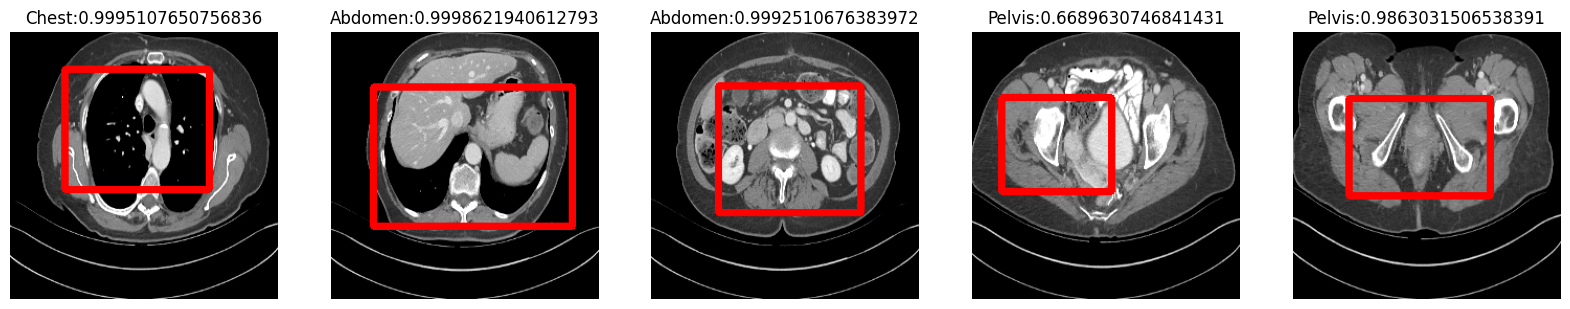

In [ ]:
displayImages_with_bbox([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

# Data Exploration using T-SNE



t-Distributed Stochastic Neighbor Embedding (t-SNE) is a statistical technique used to represent a high-dimensional dataset in two or three dimensions so that we can visualize separability. This technique was first described by Laurens van de Marten and Geoffrey Hinton in 2008 ([paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)).

This technique can be useful prior to developing an algorithm to understand how easily our data can be separated into different classes. It pairs high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. It then defines a similar probability distribution on a low dimensional map. [Here is an example of a t-SNE of the MNIST data set](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding#/media/File:T-SNE_Embedding_of_MNIST.png).

In [ ]:
#Get path of train images
trainPath = Path('bodypart/npy')
trainList = list(sorted(trainPath.glob('**/*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))
len(trainList)

4359

For the purposes of this demonstration, we will use the same "predict" function we defined earlier to quickly process the 4,359 training slices into 8 bit dicom arrays. We will ignore the prediction results.

---



In [ ]:
#Stores the uids and their processed input images. We are using the same predict function we defined earlier, however we are only concerned with the processed 8 bit image arrays
uids, X, k= predict(model, trainList, IMSIZE)

Let's store our image data into a numpy array and take a look at the shape. We have 4,359 images, each with an image pixel array of 256 x 256 pixels, and one color channel. We will have to convert our 2D image into a 1D vector representation that T-SNE can work with.

In [ ]:
X_new = np.array(X)
X_new.shape

(4359, 256, 256, 1)

In [ ]:
X_new = X_new.squeeze() #remove the color channel, since we are working in monochrome
#Reshape all the processed input images to a 2 dimensional array
X_new = X_new.reshape(X_new.shape[0],X_new.shape[1]*X_new.shape[2])
X_new.shape

(4359, 65536)

In [ ]:
#Get the labels/ground truths of the input images, and store them in a pandas dataframe.
df = pd.read_csv("bodypart/labels.csv")
Y = []
for i in range(len(trainList)):
    label = labels_dict1[df[df['npyid']==str(trainList[i]).split('/')[-1].split('.')[0]]['label'].values[0]]
    Y.append(label)

In [ ]:
#Randomly shuffle the order of input images
np.random.seed(42)
perm = np.random.permutation(X_new.shape[0])
Y_new = np.array(Y)
X_new.shape,Y_new.shape

((4359, 65536), (4359,))

In [ ]:
#x_new = X_new #If you want all points
#y_new = Y_new #If you want all points
x_new = X_new[perm][:3000] #Select random 3000 samples
y_new = Y_new[perm][:3000] #Select random 3000 samples

We will use the t-SNE tool defined in the scikit learn package. We simply import the TSNE class, pass it our data (the images are in x_new, and the labels are in y_new), and then plot it.

In [ ]:
#Plot t-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_new)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.069s...
[t-SNE] Computed neighbors for 3000 samples in 41.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 48.617835
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.628937
[t-SNE] KL divergence after 1000 iterations: 0.704130


In [ ]:
df = pd.DataFrame()
df["y"] = y_new
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df = df.replace({'y':labels_dict2})
print(df['y'].value_counts())

Pelvis     1136
Chest       948
Abdomen     916
Name: y, dtype: int64


[Text(0.5, 1.0, 'T-SNE')]

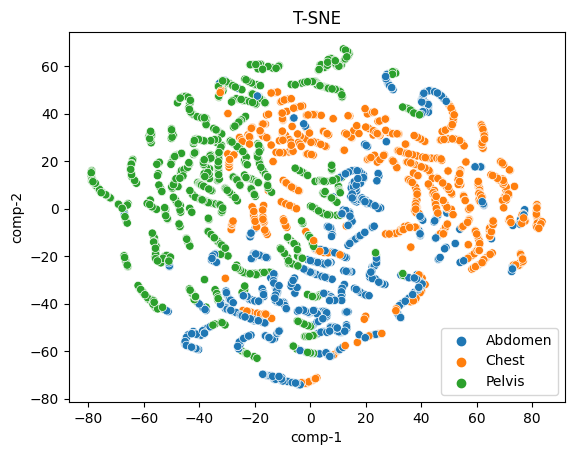

In [ ]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="T-SNE")

# References

[1] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D. & Batra, D. (2017). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization.. ICCV (p./pp. 618-626), : IEEE Computer Society. ISBN: 978-1-5386-1032-9

[2] van der Maaten, L. & Hinton, G. (2008). Visualizing Data using t-SNE . Journal of Machine Learning Research, 9, 2579--2605.

